In [ ]:
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'


import astropy
import astropy.io as io
import astropy.units as units
import specutils
from tqdm import tqdm

import inspect

import FunctionLib as FL
import warnings
warnings.filterwarnings("ignore")


DJA_File_Path_str=os.path.expanduser('~/DJAv4/')

DJA_Catalog_DataFrame=pd.read_csv(os.path.expanduser('~/DustCurve/DJAv4Catalog.csv'))
DJA_File_List_All=[]
number_file=0

if os.path.exists(DJA_File_Path_str):
    for root_dir in os.listdir(DJA_File_Path_str):
        if root_dir.startswith('.'):
            continue
        Root_File_Path_str=os.path.join(DJA_File_Path_str, root_dir)
        DJA_File_List=np.array(os.listdir(Root_File_Path_str))
        number_file+=len(DJA_File_List)
        for file_name in DJA_File_List:
            if file_name.endswith('.fits'):
                DJA_File_List_All.append(os.path.join(Root_File_Path_str, file_name))

print('Number of files in DJAv4:', number_file)

redshift_is=np.where(DJA_Catalog_DataFrame['z']!= np.nan)[0]



In [ ]:
class Spectrum_1d:
    """

    A class to store and manipulate a 1D spectrum. The initialization requires the observed
    wavelengths, fluxes in F_nu or F_lambda units, and the redshift value. The initialization
    will automatically calculate the rest frame wavelengths based on the observed wavelengths
    and redshift and store them as astropy.nddata.NDDataArray objects.

    Attributes
    ----------
    observed_wavelengths : astropy.nddata.NDDataArray
        The observed wavelengths of the spectrum, should contain the unit.
    observed_flux_nu : astropy.nddata.NDDataArray
        The observed flux values of the spectrum in F_nu units, should contain the unit and uncertainty.
    observed_flux_lambda : astropy.nddata.NDDataArray
        The observed flux values of the spectrum in F_lambda units, should contain the unit and uncertainty.
    redshift : astropy.units.Quantity
        The redshift value of the spectrum.
    restframe_wavelengths : astropy.nddata.NDDataArray
        The rest frame wavelengths of the spectrum, calculated from the observed wavelengths and redshift.
    processing_wavelengths : astropy.nddata.NDDataArray
        The processing wavelengths of the spectrum, which can be either observed or rest frame depending on the input. Here used to store the wavelengths that are currently being processed or analyzed.
    processing_flux: astropy.nddata.NDDataArray
        The processing flux values of the spectrum, which can be either F_nu or F_lambda depending on the input. Here used to store the flux that is currently being processed or analyzed.
    """

    def __init__(self, observed_wavelengths, redshift, observed_flux_nu=None, observed_flux_lambda=None):
        """
        Initializes the Spectrum_1d object with the given parameters.

        Parameters
        ----------
        observed_wavelengths : astropy.nddata.NDDataArray or astropy.units.Quantity
            The observed wavelengths of the spectrum, should contain the unit.
        redshift : float, int, or astropy.units.Quantity
            The redshift value of the spectrum.
        observed_flux_nu : astropy.nddata.NDDataArray or astropy.units.Quantity, optional
            The observed flux values of the spectrum in F_nu units, should contain the unit and uncertainty.
        observed_flux_lambda : astropy.nddata.NDDataArray or astropy.units.Quantity, optional
            The observed flux values of the spectrum in F_lambda units, should contain the unit and uncertainty.
        """
        # Check that at least one flux is provided
        if observed_flux_lambda is None and observed_flux_nu is None:
            raise ValueError("At least one of observed_flux_nu or observed_flux_lambda must be provided.")

        # Handle wavelengths - allow both NDDataArray and Quantity
        if isinstance(observed_wavelengths, astropy.nddata.NDDataArray):
            self.observed_wavelengths = observed_wavelengths
        elif isinstance(observed_wavelengths, astropy.units.Quantity):
            # If input is a Quantity, NDDataArray stores it in its .data attribute
            self.observed_wavelengths = astropy.nddata.NDDataArray(observed_wavelengths)
        else:
            raise TypeError("observed_wavelengths must be an astropy.nddata.NDDataArray or astropy.units.Quantity object.")

        # Handle redshift
        if isinstance(redshift, (float, int)):
            self.redshift = redshift * astropy.units.dimensionless_unscaled
        elif isinstance(redshift, astropy.units.Quantity):
            if redshift.unit.is_equivalent(astropy.units.dimensionless_unscaled):
                self.redshift = redshift
            else:
                raise ValueError("Redshift must be dimensionless.")
        else:
            raise TypeError("Redshift must be a float, int, or dimensionless astropy.units.Quantity.")

        # Calculate rest-frame wavelengths
        # Get the observed wavelength data, which might be a Quantity or ndarray
        obs_wave_data_attr = self.observed_wavelengths.data
        if isinstance(obs_wave_data_attr, astropy.units.Quantity):
            obs_wave_values = obs_wave_data_attr.value
        else:
            obs_wave_values = obs_wave_data_attr # Assuming it's a numpy array

        rest_wave_data = obs_wave_values / (1 + self.redshift.value)

        rest_wave_uncertainty_values = None
        if self.observed_wavelengths.uncertainty is not None:
            # Assuming uncertainty.array gives the numerical values of uncertainty
            # and it needs to be scaled like the data.
            rest_wave_uncertainty_values = self.observed_wavelengths.uncertainty.array / (1 + self.redshift.value)
            # Reconstruct the uncertainty object with the new values
            rest_wave_uncertainty = type(self.observed_wavelengths.uncertainty)(rest_wave_uncertainty_values)
        else:
            rest_wave_uncertainty = None

        self.restframe_wavelengths = astropy.nddata.NDDataArray(
            data=rest_wave_data, # This data is a numpy array
            uncertainty=rest_wave_uncertainty,
            unit=self.observed_wavelengths.unit # Unit is preserved
        )

        # Handle F_nu flux
        if observed_flux_nu is not None:
            if isinstance(observed_flux_nu, astropy.nddata.NDDataArray):
                self.observed_flux_nu = observed_flux_nu
            elif isinstance(observed_flux_nu, astropy.units.Quantity):
                self.observed_flux_nu = astropy.nddata.NDDataArray(observed_flux_nu) # .data will be the Quantity
            else:
                raise TypeError("observed_flux_nu must be an astropy.nddata.NDDataArray or astropy.units.Quantity object.")

            target_unit_nu = astropy.units.erg / (astropy.units.cm**2 * astropy.units.s * astropy.units.Hz)
            # Check unit equivalency using the actual quantity
            flux_nu_data_attr = self.observed_flux_nu.data
            if isinstance(flux_nu_data_attr, astropy.units.Quantity):
                current_flux_nu_q = flux_nu_data_attr
            else:
                current_flux_nu_q = flux_nu_data_attr * self.observed_flux_nu.unit

            # if not current_flux_nu_q.unit.is_equivalent(target_unit_nu):
            #     raise ValueError(f"observed_flux_nu units ({current_flux_nu_q.unit}) must be equivalent to {target_unit_nu}")
        else:
            self.observed_flux_nu = None

        # Handle F_lambda flux
        if observed_flux_lambda is not None:
            if isinstance(observed_flux_lambda, astropy.nddata.NDDataArray):
                self.observed_flux_lambda = observed_flux_lambda
            elif isinstance(observed_flux_lambda, astropy.units.Quantity):
                self.observed_flux_lambda = astropy.nddata.NDDataArray(observed_flux_lambda) # .data will be the Quantity
            else:
                raise TypeError("observed_flux_lambda must be an astropy.nddata.NDDataArray or astropy.units.Quantity object.")

            target_unit_lambda = astropy.units.erg / (astropy.units.cm**2 * astropy.units.s * astropy.units.AA)
            # Check unit equivalency
            flux_lambda_data_attr = self.observed_flux_lambda.data
            if isinstance(flux_lambda_data_attr, astropy.units.Quantity):
                current_flux_lambda_q = flux_lambda_data_attr
            else:
                current_flux_lambda_q = flux_lambda_data_attr * self.observed_flux_lambda.unit

            # if not current_flux_lambda_q.unit.is_equivalent(target_unit_lambda):
            #     raise ValueError(f"observed_flux_lambda units ({current_flux_lambda_q.unit}) must be equivalent to {target_unit_lambda}")
        else:
            self.observed_flux_lambda = None

        # Auto-convert between flux types if only one is provided
        if self.observed_flux_nu is None and self.observed_flux_lambda is not None:
            self._convert_lambda_to_nu()
        elif self.observed_flux_lambda is None and self.observed_flux_nu is not None:
            self._convert_nu_to_lambda()

        self.processing_flux = self.observed_flux_lambda if self.observed_flux_lambda is not None else self.observed_flux_nu
        self.processing_wavelengths = self.restframe_wavelengths if self.restframe_wavelengths is not None else self.observed_wavelengths

        self.processing_wavelengths = self.processing_wavelengths.convert_unit_to(
            astropy.units.AA)

        # Handle NaN values by converting them to 0
        self._handle_nan_values()

    def _handle_nan_values(self):
        """Convert NaN values to 0 in wavelengths and fluxes."""

        # Handle observed wavelengths
        if self.observed_wavelengths is not None:
            obs_wave_data = self.observed_wavelengths.data
            if isinstance(obs_wave_data, astropy.units.Quantity):
                nan_mask = np.isnan(obs_wave_data.value)
                if np.any(nan_mask):
                    new_values = obs_wave_data.value.copy()
                    new_values[nan_mask] = 0
                    self.observed_wavelengths.data = new_values * obs_wave_data.unit
            else:
                nan_mask = np.isnan(obs_wave_data)
                if np.any(nan_mask):
                    self.observed_wavelengths.data[nan_mask] = 0

        # Handle rest-frame wavelengths
        if self.restframe_wavelengths is not None:
            rest_wave_data = self.restframe_wavelengths.data
            if isinstance(rest_wave_data, astropy.units.Quantity):
                nan_mask = np.isnan(rest_wave_data.value)
                if np.any(nan_mask):
                    new_values = rest_wave_data.value.copy()
                    new_values[nan_mask] = 0
                    self.restframe_wavelengths.data = new_values * rest_wave_data.unit
            else:
                nan_mask = np.isnan(rest_wave_data)
                if np.any(nan_mask):
                    self.restframe_wavelengths.data[nan_mask] = 0

        # Handle observed flux nu
        if self.observed_flux_nu is not None:
            flux_nu_data = self.observed_flux_nu.data
            if isinstance(flux_nu_data, astropy.units.Quantity):
                nan_mask = np.isnan(flux_nu_data.value)
                if np.any(nan_mask):
                    new_values = flux_nu_data.value.copy()
                    new_values[nan_mask] = 0
                    self.observed_flux_nu.data = new_values * flux_nu_data.unit
            else:
                nan_mask = np.isnan(flux_nu_data)
                if np.any(nan_mask):
                    self.observed_flux_nu.data[nan_mask] = 0

            # Handle uncertainty for flux_nu if present
            if self.observed_flux_nu.uncertainty is not None:
                uncertainty_array = self.observed_flux_nu.uncertainty.array
                if uncertainty_array is not None:
                    nan_mask = np.isnan(uncertainty_array)
                    if np.any(nan_mask):
                        uncertainty_array[nan_mask] = 0

        # Handle observed flux lambda
        if self.observed_flux_lambda is not None:
            flux_lambda_data = self.observed_flux_lambda.data
            if isinstance(flux_lambda_data, astropy.units.Quantity):
                nan_mask = np.isnan(flux_lambda_data.value)
                if np.any(nan_mask):
                    new_values = flux_lambda_data.value.copy()
                    new_values[nan_mask] = 0
                    self.observed_flux_lambda.data = new_values * flux_lambda_data.unit
            else:
                nan_mask = np.isnan(flux_lambda_data)
                if np.any(nan_mask):
                    self.observed_flux_lambda.data[nan_mask] = 0

            # Handle uncertainty for flux_lambda if present
            if self.observed_flux_lambda.uncertainty is not None:
                uncertainty_array = self.observed_flux_lambda.uncertainty.array
                if uncertainty_array is not None:
                    nan_mask = np.isnan(uncertainty_array)
                    if np.any(nan_mask):
                        uncertainty_array[nan_mask] = 0

    def _get_quantity_from_nddata(self, nddata_array):
        """Helper to reliably get an astropy.units.Quantity from an NDDataArray."""
        if nddata_array is None:
            return None
        data_attr = nddata_array.data
        if isinstance(data_attr, astropy.units.Quantity):
            return data_attr
        elif nddata_array.unit is not None:
            return data_attr * nddata_array.unit
        else: # Should not happen if units are always present as per design
            raise ValueError("NDDataArray is missing unit information for quantity conversion.")

    def _convert_lambda_to_nu(self):
        """Convert F_lambda to F_nu using astropy.units.spectral_density and rest-frame wavelength."""
        if self.observed_flux_lambda is None:
            raise ValueError("Cannot convert from F_lambda: observed_flux_lambda is None.")

        F_lambda_quantity_to_convert = self._get_quantity_from_nddata(self.observed_flux_lambda)

        # For spectral_density, the wavelength needs to be a Quantity.
        # self.restframe_wavelengths.data is a numpy array, .unit is the unit.
        rest_wave_quantity = self.restframe_wavelengths.data * self.restframe_wavelengths.unit

        target_F_nu_unit = astropy.units.erg / (astropy.units.cm**2 * astropy.units.s * astropy.units.Hz)

        F_nu_converted = F_lambda_quantity_to_convert.to(
            target_F_nu_unit,
            equivalencies=astropy.units.spectral_density(rest_wave_quantity)
        )

        flux_nu_data = F_nu_converted.value

        uncertainty_nu_obj = None
        if self.observed_flux_lambda.uncertainty is not None:
            uncertainty_F_lambda_values = self.observed_flux_lambda.uncertainty.array
            # Assume uncertainty has the same unit as the flux data
            uncertainty_F_lambda_quantity = uncertainty_F_lambda_values * self.observed_flux_lambda.unit

            uncertainty_F_nu_converted = uncertainty_F_lambda_quantity.to(
                target_F_nu_unit,
                equivalencies=astropy.units.spectral_density(rest_wave_quantity)
            )
            uncertainty_nu_data = uncertainty_F_nu_converted.value
            uncertainty_nu_obj = type(self.observed_flux_lambda.uncertainty)(uncertainty_nu_data)

        self.observed_flux_nu = astropy.nddata.NDDataArray(
            data=flux_nu_data, # flux_nu_data is now a numpy array
            uncertainty=uncertainty_nu_obj,
            unit=target_F_nu_unit
        )

    def _convert_nu_to_lambda(self):
        """Convert F_nu to F_lambda using astropy.units.spectral_density and rest-frame wavelength."""
        if self.observed_flux_nu is None:
            raise ValueError("Cannot convert from F_nu: observed_flux_nu is None.")

        F_nu_quantity_to_convert = self._get_quantity_from_nddata(self.observed_flux_nu)

        # For spectral_density, the wavelength needs to be a Quantity.
        rest_wave_quantity = self.restframe_wavelengths.data * self.restframe_wavelengths.unit

        target_F_lambda_unit = astropy.units.erg / (astropy.units.cm**2 * astropy.units.s * astropy.units.AA)

        F_lambda_converted = F_nu_quantity_to_convert.to(
            target_F_lambda_unit,
            equivalencies=astropy.units.spectral_density(rest_wave_quantity)
        )

        flux_lambda_data = F_lambda_converted.value

        uncertainty_lambda_obj = None
        if self.observed_flux_nu.uncertainty is not None:
            uncertainty_F_nu_values = self.observed_flux_nu.uncertainty.array
            # Assume uncertainty has the same unit as the flux data
            uncertainty_F_nu_quantity = uncertainty_F_nu_values * self.observed_flux_nu.unit

            uncertainty_F_lambda_converted = uncertainty_F_nu_quantity.to(
                target_F_lambda_unit,
                equivalencies=astropy.units.spectral_density(rest_wave_quantity)
            )
            uncertainty_lambda_data = uncertainty_F_lambda_converted.value
            uncertainty_lambda_obj = type(self.observed_flux_nu.uncertainty)(uncertainty_lambda_data)

        self.observed_flux_lambda = astropy.nddata.NDDataArray(
            data=flux_lambda_data, # flux_lambda_data is now a numpy array
            uncertainty=uncertainty_lambda_obj,
            unit=target_F_lambda_unit
        )


    def set_boundarys(self, lower_boundary=None, upper_boundary=None):
        """
        Set the lower and upper boundaries for the spectrum.

        Parameters
        ----------
        lower_boundary : astropy.units.Quantity, optional
            The lower boundary of the spectrum. If None, no lower boundary is set.
        upper_boundary : astropy.units.Quantity, optional
            The upper boundary of the spectrum. If None, no upper boundary is set.
        """
        if lower_boundary is not None and upper_boundary is None:
            lower_boundary = lower_boundary.to(self.restframe_wavelengths.unit)
            indices= self.restframe_wavelengths.data >= lower_boundary.value
            self.processing_wavelengths = self.restframe_wavelengths[indices]
            self.processing_flux = self.observed_flux_lambda[indices] if self.observed_flux_lambda is not None else self.observed_flux_nu[indices]
        if upper_boundary is not None and lower_boundary is None:
            upper_boundary = upper_boundary.to(self.restframe_wavelengths.unit)
            indices= self.restframe_wavelengths.data <= upper_boundary.value
            self.processing_wavelengths = self.restframe_wavelengths[indices]
            self.processing_flux = self.observed_flux_lambda[indices] if self.observed_flux_lambda is not None else self.observed_flux_nu[indices]

        if lower_boundary is not None and upper_boundary is not None:
            lower_boundary = lower_boundary.to(self.restframe_wavelengths.unit)
            upper_boundary = upper_boundary.to(self.restframe_wavelengths.unit)
            indices = (self.restframe_wavelengths.data >= lower_boundary.value) & (self.restframe_wavelengths.data <= upper_boundary.value)
            self.processing_wavelengths = self.restframe_wavelengths[indices]
            self.processing_flux = self.observed_flux_lambda[indices] if self.observed_flux_lambda is not None else self.observed_flux_nu[indices]

        self.processing_wavelengths = self.processing_wavelengths.convert_unit_to(
            astropy.units.AA)


    def show(self):
        """Display the processed spectrum."""
        plt.figure(figsize=(20,10))
        if self.processing_wavelengths is not None and self.processing_flux is not None:
            if isinstance(self.processing_wavelengths, astropy.nddata.NDDataArray):
                wave_data = self.processing_wavelengths.data
                wave_unit = self.processing_wavelengths.unit
            else:
                wave_data = self.processing_wavelengths
                wave_unit = None

            if isinstance(self.processing_flux, astropy.nddata.NDDataArray):
                flux_data = self.processing_flux.data
                flux_unit = self.processing_flux.unit
            else:
                flux_data = self.processing_flux
                flux_unit = None

            plt.plot(wave_data, flux_data, label='Processed Spectrum')
            plt.xlabel(f'Wavelength ({wave_unit})' if wave_unit else 'Wavelength')
            plt.ylabel(f'Flux ({flux_unit})' if flux_unit else 'Flux')
            plt.title(f'Spectrum at Redshift {self.redshift.value:.3f}')
            plt.legend()
            plt.show()

    def __repr__(self):
        """String representation of the spectrum object."""
        wave_data_repr = "N/A"
        num_points_str = "N/A"

        # Check restframe wavelengths
        if self.restframe_wavelengths is not None:
            rest_wave_values = self.restframe_wavelengths.data
            if isinstance(rest_wave_values, astropy.units.Quantity):
                rest_wave_values = rest_wave_values.value
            if rest_wave_values is not None and len(rest_wave_values) > 0:
                wave_data_repr = f"{rest_wave_values.min():.2f} - {rest_wave_values.max():.2f} {self.restframe_wavelengths.unit}"
                num_points_str = str(len(rest_wave_values))
            else:
                wave_data_repr = f"Empty {self.restframe_wavelengths.unit}"
                num_points_str = "0"

        return f"Spectrum_1d(z={self.redshift.value:.3f}, λ_obs={wave_data_repr}, {num_points_str} points)"


In [ ]:
class SpectralLineFitter:
    """
    A class to fit Gaussian components to spectral lines in a spectrum.

    Attributes
    ----------
    spectrum: Spectrum_1d
        An instance of the Spectrum_1d class containing the observed wavelengths and fluxes.
    line_restframe_wavelengths: astropy.units.Quantity or list of astropy.units.Quantity
        The rest-frame wavelengths of the spectral lines to fit.
    max_components: int
        The maximum number of Gaussian components to fit to each spectral line.
    max_iterations: int
        The maximum number of iterations for the fitting process.
    fit_results: list of dict
        A list to store the fitting results for each spectral line.

    Methods
    -------
    Details of the methods will be attached after the method definitions.
    gaussian(x, amplitude, mean, stddev)

    """

    def __init__(self, spectrum, line_restframe_wavelengths, max_components=8, max_iterations=100000):
        """
        Initializes the SpectralLineFitter with a spectrum and spectral lines to fit.

        Parameters
        ----------
        spectrum: Spectrum_1d
            An instance of the Spectrum_1d class containing the observed wavelengths and fluxes.
        line_restframe_wavelengths: astropy.units.Quantity or list of astropy.units.Quantity
            The rest-frame wavelengths of the spectral lines to fit.
        max_components: int, optional
            The maximum number of Gaussian components to fit to each spectral line (default is 8).
        max_iterations: int, optional
            The maximum number of iterations for the fitting process (default is 100000).
        """

        if not isinstance(spectrum, Spectrum_1d):
            raise TypeError("spectrum must be an instance of Spectrum_1d.")

        self.spectrum = spectrum

        if isinstance(line_restframe_wavelengths, astropy.units.Quantity):
            self.line_restframe_wavelengths = [line_restframe_wavelengths]
        elif isinstance(line_restframe_wavelengths, list) and all(isinstance(w, astropy.units.Quantity) for w in line_restframe_wavelengths):
            self.line_restframe_wavelengths = line_restframe_wavelengths
        else:
            raise TypeError("line_restframe_wavelengths must be an astropy.units.Quantity or a list of astropy.units.Quantity objects.")

        self.max_components = max_components
        self.max_iterations = max_iterations
        self.fit_results = []

    def gaussian(self, x, amplitude, mean, stddev):
        """
        Gaussian function for fitting.

        Parameters
        ----------
        x : array-like
            The independent variable (wavelengths).
        amplitude : float
            The height of the Gaussian peak.
        mean : float
            The position of the center of the Gaussian.
        stddev : float
            The standard deviation (width) of the Gaussian.

        Returns
        -------
        array-like
            The values of the Gaussian function at x.
        """
        if isinstance(x, astropy.nddata.NDDataArray):
            x = x.data
            return astropy.nddata.NDDataArray(
                data=amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2),
                unit=x.unit
            )
        elif isinstance(x, astropy.units.Quantity):
            return amplitude * np.exp(-0.5 * ((x.value - mean) / stddev) ** 2) * x.unit
        else:
            return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

    def fit_single_gaussian(self,initial_guess=None):
        """
        Fits a single Gaussian to the spectrum data, the initial guess will be generated based on the observed fluxes.

        Returns
        -------
        dict
            A dictionary containing the fit results, including the fitted parameters and the covariance matrix.
        """

        try:
            # Extract observed wavelengths and fluxes
            obs_wavelengths = self.spectrum.processing_wavelengths.convert_unit_to(astropy.units.AA).data
            obs_flux_lambda = self.spectrum.processing_flux.data
            #NumPy array

            # Initial guess for the Gaussian parameters
            amplitude_guess = obs_flux_lambda.max()  # Initial guess for the amplitude
            mean_guess = obs_wavelengths[np.argmax(obs_flux_lambda)]  # Initial guess for the mean (wavelength of max flux)
            stddev_guess = 10 * astropy.units.AA  # Initial guess for the width, can be adjusted
            #int or float here

            if initial_guess is not None:
                amplitude_guess = initial_guess[0]
                mean_guess = initial_guess[1]
                stddev_guess = initial_guess[2] * astropy.units.AA
            elif not isinstance(stddev_guess, astropy.units.Quantity):
                raise TypeError("stddev_guess must be an astropy.units.Quantity object.")
            else:
                stddev_guess = stddev_guess.to(astropy.units.AA)
                initial_guess = [amplitude_guess, mean_guess, stddev_guess.value]

            #print(f"Initial guess for Gaussian parameters: {initial_guess}")

            # Fit the Gaussian using scipy.optimize.curve_fit

            popt, pcov = scipy.optimize.curve_fit(self.gaussian,
                                                    obs_wavelengths,
                                                    obs_flux_lambda,
                                                    p0=initial_guess,
                                                    maxfev=self.max_iterations)

            y_fit = self.gaussian(obs_wavelengths, *popt)

            integrated_flux, integration_error = scipy.integrate.quad(self.gaussian, obs_wavelengths.min(), obs_wavelengths.max(), args=tuple(popt),epsabs=0)* self.spectrum.processing_flux.unit* self.spectrum.processing_wavelengths.unit

            return {
                    'success': True,
                    'parameters': {
                        'amplitude': popt[0] * self.spectrum.processing_flux.unit,
                        'mean': popt[1] * astropy.units.AA,
                        'stddev': popt[2] * astropy.units.AA,
                    },
                    'fitted_curve': astropy.nddata.NDDataArray(
                        data=y_fit,
                        unit=self.spectrum.processing_flux.unit
                    ),
                    'covariance': pcov,
                    'integrated_flux': integrated_flux,
                    'integration_error': integration_error
                }
        except Exception as e:
            return {
                'success': False,
                'error': str(e)
            }

    def check_line(self, line_restframe_wavelength, mean_fit, tolerance=10* astropy.units.AA):
        """
        Checks if the line_restframe_wavelength is within the tolerance of the mean_fit.

        Parameters
        ----------
        line_restframe_wavelength : astropy.units.Quantity
            The rest-frame wavelength of the spectral line.
        mean_fit : astropy.units.Quantity
            The mean wavelength from the Gaussian fit.
        tolerance : astropy.units.Quantity, optional
            The tolerance range for checking (default is 10 * astropy.units.AA).

        Returns
        -------
        bool
            True if the line is within the tolerance, False otherwise.
        """
        if not isinstance(line_restframe_wavelength, astropy.units.Quantity):
            raise TypeError("line_restframe_wavelength must be an astropy.units.Quantity object.")
        if not isinstance(mean_fit, astropy.units.Quantity):
            raise TypeError("mean_fit must be an astropy.units.Quantity object.")
        if not isinstance(tolerance, astropy.units.Quantity):
            raise TypeError("tolerance must be an astropy.units.Quantity object.")

        return abs(line_restframe_wavelength - mean_fit) <= tolerance

    def plot_fit_result(self, fit_result, component_index=0, is_residual=False):
        """
        Plots the fit result with Gaussian components fit overlay.

        Parameters
        ----------
        fit_result : dict
            The fit result dictionary containing the fitted parameters and the fitted curve, should be generated by fit_single_gaussian.
        component_index : int, optional
            The index of the component to plot (default is 0).
        is_residual : bool, optional
            If True, plot the residuals instead of the fitted curve (default is False).
        """
        if not isinstance(fit_result, dict):
            raise TypeError("fit_result must be a dictionary containing the fit results.")

        if 'fitted_curve' not in fit_result or 'parameters' not in fit_result:
            raise ValueError("fit_result must contain 'fitted_curve' and 'parameters' keys.")

        obs_wavelengths = self.spectrum.processing_wavelengths.convert_unit_to(astropy.units.AA).data
        obs_flux_lambda = self.spectrum.processing_flux.data

        fig,ax= plt.subplots(figsize=(20, 10))

        if is_residual:
            ax.plot(obs_wavelengths, obs_flux_lambda, label=f"Residual Spectrum {component_index}", color='blue', alpha=0.5)
            title=f'Component {component_index} - Gaussian Fit Residuals'

        else:
            ax.plot(obs_wavelengths, obs_flux_lambda, label=f"Observed Spectrum {component_index}", color='blue', alpha=0.5)
            title=f'Component {component_index} - Gaussian Fit Result'

        if fit_result['success']:
            ax.plot(obs_wavelengths, fit_result['fitted_curve'].data, label=f"Fitted Curve {component_index}", color='red', alpha=0.7)

        ax.set_xlabel("Wavelength (Angstrom)", fontsize=14)
        ax.set_ylabel("Flux (erg/cm^2/s/Angstrom)", fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.legend()
        ax.set_xlim(obs_wavelengths.min(), obs_wavelengths.max())

        if not is_residual:
            flux_margin= 0.1 * np.nanmax(obs_flux_lambda)
            ax.set_ylim(np.nanmin(obs_flux_lambda) - flux_margin, np.nanmax(obs_flux_lambda) + flux_margin)

        plt.grid()
        plt.show()

    def print_fit_summary(self, fit_result, component_index=0):
        """
        Prints a summary of the fit results for a specific component.

        Parameters
        ----------
        fit_result : dict
            The fit result dictionary containing the fitted parameters and the covariance matrix, should be generated by fit_single_gaussian.
        component_index : int, optional
            The index of the component to print the summary for (default is 0).
        """
        if not isinstance(fit_result, dict):
            raise TypeError("fit_result must be a dictionary containing the fit results.")

        if 'parameters' not in fit_result or 'covariance' not in fit_result:
            raise ValueError("fit_result must contain 'parameters' and 'covariance' keys.")

        if fit_result['success']:
            params = fit_result['parameters']
            print(f"\n{'='*60}")
            print(f"Component {component_index} Fit Parameters:")
            print(f"Amplitude: {params['amplitude']:.3e}")
            print(f"Mean (Rest-frame Wavelength): {params['mean']:.3f} ")
            print(f"Standard Deviation (Width): {params['stddev']:.3f}")
            print(f"Integrated Flux: {fit_result['integrated_flux']:.3e}")
            print(f"Integration Error: {fit_result['integration_error']:.3e}")
            print(f"Covariance Matrix:\n{fit_result['covariance']}")
            print(f"{'='*60}\n")

        else:
            print(f"\n{'='*60}")
            print(f"Component {component_index} Fit Failed: {fit_result['error']}")
            print(f"{'='*60}\n")

    def iterative_gaussian_fitting(self, line_restframe_wavelength, tolerance=10 * astropy.units.AA, plot_results=True):
        """
        Iteratively fits Gaussian components to a spectral line until the fit is successful or the maximum number of components is reached.

        Parameters
        ----------
        line_restframe_wavelength : astropy.units.Quantity
            The rest-frame wavelength of the spectral line to fit.
        tolerance : astropy.units.Quantity, optional
            The tolerance range for checking the fit (default is 10 * astropy.units.AA).
        plot_results : bool, optional
            If True, plots the fit results (default is True).

        Returns
        -------
        tuple
            A tuple containing:
            - fit_result: list of dict
                The fit results for each component, including the fitted parameters and the covariance matrix.
            - line_integrated_flux: astropy.units.Quantity
                The integrated flux of the spectral line.
        """

        self.fit_results = []  # Reset fit results for each line
        line_integrated_flux = 0 * self.spectrum.processing_flux.unit * self.spectrum.processing_wavelengths.unit

        for component_index in range(self.max_components):

            if not isinstance(line_restframe_wavelength, astropy.units.Quantity):
                raise TypeError("line_restframe_wavelength must be an astropy.units.Quantity object.")

            # print(f"\n{'='*60}")
            # print(f"Fitting Component {component_index + 1} for Line at {line_restframe_wavelength:.3f}")
            # print(f"Tolerance: {tolerance:.3f}")
            # print(f"{'='*60}")

            if component_index ==self.max_components - 1:
                indice= np.argmin(
                    (self.spectrum.processing_wavelengths.data - line_restframe_wavelength.value))
                initial_guess= [self.spectrum.processing_flux.data[indice],
                                line_restframe_wavelength.value,
                                5]
            else:
                initial_guess = None

            fit_result= self.fit_single_gaussian(initial_guess=initial_guess)
            if not fit_result['success']:
                print(f"Component {component_index + 1} fit failed: {fit_result['error']}")
                quit()

            # if not fit_result['success']:
            #     print(f"Component {component_index + 1} fit failed: {fit_result['error']}")
            #     break

            fit_result['component_index'] = component_index
            fit_result['line_restframe_wavelength'] = line_restframe_wavelength
            fit_result['is_within_tolerance'] = self.check_line(
                line_restframe_wavelength,
                fit_result['parameters']['mean'],
                tolerance=tolerance
            )

            self.fit_results.append(fit_result)

            # self.print_fit_summary(fit_result, component_index)

            if plot_results:
                is_residual=component_index > 0
                self.plot_fit_result(fit_result, component_index, is_residual=is_residual)

            self.spectrum.processing_flux = astropy.nddata.NDDataArray(
                data=self.spectrum.processing_flux.data - fit_result['fitted_curve'].data,
                unit=self.spectrum.processing_flux.unit
            )

            if plot_results and component_index< self.max_components - 1:
                plt.figure(figsize=(20, 10))
                plt.plot(self.spectrum.processing_wavelengths.data, self.spectrum.processing_flux.data, label=f"Residual Spectrum after Component {component_index + 1}", color='blue', alpha=0.5)
                plt.xlabel("Wavelength (Angstrom)", fontsize=14)
                plt.ylabel("Flux (erg/cm^2/s/Angstrom)", fontsize=14)
                plt.title(f"Residual Spectrum after Component {component_index + 1} Fitting", fontsize=16)
                plt.legend()
                plt.xlim(self.spectrum.processing_wavelengths.data.min(), self.spectrum.processing_wavelengths.data.max())
                flux_margin = 0.1 * np.nanmax(self.spectrum.processing_flux.data)
                plt.ylim(np.nanmin(self.spectrum.processing_flux.data) - flux_margin, np.nanmax(self.spectrum.processing_flux.data) + flux_margin)
                plt.grid()
                plt.show()

            if fit_result['is_within_tolerance']:
                #print(f"Component {component_index} is within tolerance for line at {line_restframe_wavelength:.3f}.")
                line_integrated_flux += fit_result['integrated_flux']
                break


        if len(self.fit_results) ==0:
            print("No successful fits were made.")
            return [], line_integrated_flux

    def get_line_components(self):
        """
        Returns the fitted components from the fit results.

        Returns
        -------
        Dict or None
            A dictionary containing the fitted components, or None if no fits were made.
        """

        for fit_result in self.fit_results:
            if fit_result.get('is_within_tolerance', True):
                return {
                    'component_index': fit_result['component_index'],
                    'line_restframe_wavelength': fit_result['line_restframe_wavelength'],
                    'parameters': fit_result['parameters'],
                    'integrated_flux': fit_result['integrated_flux'],
                    'integration_error': fit_result['integration_error']
                }
        return None

    def plot_final_decomposition(self, line_restframe_wavelength,figure_name=None):
        """
        Plots the final decomposition of the spectral line with all fitted components.

        Parameters
        ----------
        line_restframe_wavelength : astropy.units.Quantity
            The rest-frame wavelength of the spectral line to plot.
        tolerance : astropy.units.Quantity, optional
            The tolerance range for checking the fit (default is 10 * astropy.units.AA).
        """

        self.spectrum.processing_wavelengths=self.spectrum.processing_wavelengths.convert_unit_to(astropy.units.AA)
        self.spectrum.processing_flux=self.spectrum.processing_flux.convert_unit_to(astropy.units.erg / (astropy.units.cm**2 * astropy.units.s * astropy.units.AA))

        subindices= np.where(
            (self.spectrum.restframe_wavelengths.convert_unit_to(astropy.units.AA).data>=self.spectrum.processing_wavelengths.data.min()) &
            (self.spectrum.restframe_wavelengths.convert_unit_to(astropy.units.AA).data<=self.spectrum.processing_wavelengths.data.max())
        )[0]

        plt.figure(figsize=(20, 10))

        plt.step(self.spectrum.processing_wavelengths.data, self.spectrum.observed_flux_lambda.data[subindices], label="Observed Spectrum", color='blue', alpha=0.5, linewidth=1.6)

        colors = ['red', 'blue', 'green', 'orange', 'purple']

        for i, fit_result in enumerate(self.fit_results):
            if fit_result['success']:

                params= [fit_result['parameters']['amplitude'].value,
                         fit_result['parameters']['mean'].value,
                            fit_result['parameters']['stddev'].value]

                component_flux= self.gaussian(
                    self.spectrum.processing_wavelengths.data, *params
                )

                label= f"Component {fit_result['component_index']}"

                if fit_result['is_within_tolerance']:
                    label+=f'(Line at {line_restframe_wavelength:.3f})'

                plt.plot(
                    self.spectrum.processing_wavelengths.data,
                    component_flux,
                    label=label,
                    color=colors[i % len(colors)],
                    alpha=0.7
                )

        plt.xlabel("Wavelength (Angstrom)", fontsize=14)
        plt.ylabel("Flux (erg/cm^2/s/Angstrom)", fontsize=14)
        plt.title(f"Final Decomposition for Line at {line_restframe_wavelength:.3f}", fontsize=16)
        plt.legend()
        plt.xlim(self.spectrum.processing_wavelengths.data.min(), self.spectrum.processing_wavelengths.data.max())
        flux_margin = 0.1 * np.nanmax(self.spectrum.observed_flux_lambda.data[subindices])
        plt.ylim(np.nanmin(self.spectrum.observed_flux_lambda.data[subindices]) - flux_margin, np.nanmax(self.spectrum.observed_flux_lambda.data[subindices]) + flux_margin)
        plt.grid()
        plt.savefig(f"./fig/Final_Decomposition_{figure_name if figure_name else 'spectrum'}.png")
        plt.close()




In [ ]:
def load_Redshift_From_DJA_Catalog(DJA_Catalog, file_name):
    """
    Load the redshift from a DJA catalog DataFrame based on the file name.

    Parameters
    ----------
    DJA_Catalog : pandas.DataFrame
        A DataFrame containing the DJA catalog.
    file_name : str
        The name of the file to search for in the catalog.

    Returns
    -------
    astropy.units.Quantity
        The redshift value as an astropy.units.Quantity object.

    Raises
    ------
    ValueError
        If the file name is not found in the catalog.
    """
    if not isinstance(DJA_Catalog, pd.DataFrame):
        raise TypeError("DJA_Catalog must be a pandas DataFrame.")

    if not isinstance(file_name, str):
        raise TypeError("file_name must be a string.")

    filter_name=file_name.split('_')[1]
    object_id=file_name.split('_')[2]+'_'+file_name.split('_')[3].split('.')[0]
    print(f"filter_name: {filter_name}")
    print(f"object_id: {object_id}")

    return None



def load_DJA_fits_to_spectrum1d(file_path, redshift=None,DJA_Catalog=None):
    """
    Load a spectrum class from a DJA FITS file.

    Parameters
    ----------
    file_path : str
        The path to the DJA FITS file.
    redshift : astropy.units.Quantity, optional
        The redshift of the spectrum. If None, it will be loaded from the DJA catalog.
    DJA_Catalog : pandas.DataFrame, optional
        A DataFrame containing the DJA catalog. If None, it will be loaded from the default DJA catalog.

    Returns
    -------
    Spectrum_1d
        An instance of the Spectrum_1d class containing the loaded spectrum data.

    """

    if not isinstance(file_path, str):
        raise TypeError("filename must be a string representing the path to the DJA FITS file.")
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    if redshift is not None and not isinstance(redshift, astropy.units.Quantity):
        raise TypeError("redshift must be an astropy.units.Quantity object.")
    if DJA_Catalog is not None and not isinstance(DJA_Catalog, pd.DataFrame):
        raise TypeError("DJA_Catalog must be a pandas DataFrame.")
    if redshift is None and DJA_Catalog is None:
        raise ValueError("Either redshift or DJA_Catalog must be provided.")

    fits_filename=file_path.split('/')[-1]
    fits_prism_clear_fileame=fits_filename.replace(fits_filename.split('.')[-1],'prism_clear')



In [ ]:
for file_path_str in DJA_File_List_All[0:5]:


In [ ]:
import re
from collections import defaultdict

In [ ]:
object_counts_dictionary=defaultdict(int)
prism=list()
pattern_re=r'^([^_]+)_([^_]+)_(\d+)_([a-zA-Z0-9]+)\.spec.fits$'

for file_path_str in tqdm(DJA_File_List_All):
    file_name_str = file_path_str.split('/')[-1]
    match = re.match(pattern_re, file_name_str)
    if match:
        root_name, filter_name, object_id, subobject_id = match.groups()
        object_name=f"{root_name}_{object_id}_{subobject_id}"
        object_counts_dictionary[object_name] += 1

        if filter_name == 'prism-clear':
            prism.append(file_path_str)
    else:
        print(f"File name {file_name_str} does not match the expected pattern.")

In [ ]:
result_df= pd.DataFrame.from_dict(object_counts_dictionary, orient='index', columns=['count']).reset_index()

In [ ]:
value_counts = result_df['count'].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(value_counts.index, value_counts.values, color='skyblue')
x_ticks=np.arange(0, result_df['count'].max() + 1, 1)
plt.xticks(x_ticks)
plt.xlabel('Number of Spectrums per Object')
plt.ylabel('Number of Objects')
plt.title('Distribution of Spectrums per Object')

In [ ]:
len(prism_spectrum_list_all)

In [ ]:
prism_spectrum_list_has_redshift=list()
redshift_list=list()
def find_redshift(dataframe, filepath):
    file_name= filepath.split('/')[-1]

    index= dataframe[dataframe['file'] == file_name].index

    if len(index) > 0:
        redshift= dataframe.loc[index[0], 'z']
        if isinstance(redshift, (int, float)):
            if not np.isnan(redshift):
                prism_spectrum_list_has_redshift.append(filepath)
                redshift_list.append(redshift)
    else:
        print(f"File {file_name} not found in the DataFrame.")


In [ ]:
for file_path in tqdm(prism):
    find_redshift(DJA_Catalog_DataFrame, file_path)

In [ ]:
len(redshift_list)

In [ ]:
prism_spectrum_list_has_redshift=np.array(prism_spectrum_list_has_redshift)
redshift_list=np.array(redshift_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import glob
import os
from typing import List, Tuple, Optional


def process_spectrum_to_rest_frame(fits_file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    处理单个FITS文件，返回矫正到rest frame的光谱

    Parameters:
    fits_file_path: FITS文件路径

    Returns:
    wavelength: rest frame波长数组
    flux: 对应的flux数组

    注意：这个函数需要你根据实际的FITS文件格式来实现
    """
    # 这里是示例实现，你需要根据实际情况修改
    from astropy.io import fits

    # 读取FITS文件
    with fits.open(fits_file_path) as hdul:
        # 假设光谱数据在第一个扩展中
        data = hdul[1].data
        header = hdul[1].header

        # 获取波长和flux（根据你的FITS文件结构调整）
        wavelength = data['wave']  # 或者从header计算
        flux = data['flux']

        # 获取红移信息（如果存储在header中）
        redshift = redshift_list[np.where(prism_spectrum_list_has_redshift == fits_file_path)[0][0]] if fits_file_path in prism_spectrum_list_has_redshift else 0.0
        # 矫正到rest frame
        rest_wavelength = wavelength / (1 + redshift)

    return rest_wavelength, flux

def create_nirspec_prism_plot(fits_files: List[str],
                            redshifts: Optional[List[float]] = None,
                            output_path: str = 'nirspec_prism_plot.png',
                            figsize: Tuple[int, int] = (12, 10),
                            dpi: int = 300,
                            wavelength_range: Tuple[float, float] = (0.6, 5.3),
                            redshift_range: Tuple[float, float] = (0.5, 12.0),
                            colormap: str = 'plasma'):
    """
    创建NIRSpec PRISM风格的光谱图

    Parameters:
    fits_files: FITS文件路径列表
    redshifts: 对应的红移列表（如果不在FITS文件中）
    output_path: 输出图片路径
    figsize: 图片尺寸
    dpi: 图片分辨率
    wavelength_range: 波长范围 (microns)
    redshift_range: 红移范围
    colormap: 颜色映射
    """

    fig, ax = plt.subplots(figsize=figsize, facecolor='white')

    # 设置颜色映射
    cmap = get_cmap(colormap)
    norm = Normalize(vmin=redshift_range[0], vmax=redshift_range[1])

    # 处理每个光谱文件
    for i, fits_file in enumerate(fits_files):
        try:
            # 获取rest frame光谱
            wavelength, flux = process_spectrum_to_rest_frame(fits_file)

            # 获取红移
            if redshifts is not None:
                z = redshifts[i]
            else:
                # 尝试从文件名或其他方式获取红移
                z = extract_redshift_from_filename(fits_file)

            # 过滤波长范围
            mask = (wavelength >= wavelength_range[0]) & (wavelength <= wavelength_range[1])
            wavelength = wavelength[mask]
            flux = flux[mask]

            # 归一化flux用于显示
            flux_normalized = normalize_flux_for_display(flux, z)

            # 绘制光谱
            color = cmap(norm(z))
            ax.plot(wavelength, flux_normalized + z,
                   color=color, linewidth=0.5, alpha=0.8)

            # 填充光谱下方区域以增强视觉效果
            ax.fill_between(wavelength, z, flux_normalized + z,
                          color=color, alpha=0.3)

        except Exception as e:
            print(f"处理文件 {fits_file} 时出错: {e}")
            continue

    # 设置图像样式
    setup_plot_style(ax, wavelength_range, redshift_range)

    # 添加颜色条
    add_colorbar(fig, ax, cmap, norm, redshift_range)

    # 保存图片
    plt.savefig(output_path, dpi=dpi, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

def extract_redshift_from_filename(filename: str) -> float:
    """
    从文件名中提取红移信息
    你需要根据文件命名规则来实现这个函数
    """
    # 示例：假设文件名包含 z1.23 这样的模式
    import re
    match = re.search(r'z(\d+\.?\d*)', os.path.basename(filename))
    if match:
        return float(match.group(1))
    return 1.0  # 默认红移

def normalize_flux_for_display(flux: np.ndarray, redshift: float,
                              scale_factor: float = 1.0) -> np.ndarray:
    """
    归一化flux用于显示
    """
    # 移除NaN和无限值
    flux_clean = flux[np.isfinite(flux)]
    if len(flux_clean) == 0:
        return np.zeros_like(flux)

    # 计算统计量用于归一化
    median_flux = np.median(flux_clean)
    std_flux = np.std(flux_clean)

    # 归一化
    if std_flux > 0:
        flux_norm = (flux - median_flux) / std_flux * scale_factor
    else:
        flux_norm = flux - median_flux

    # 限制范围避免过大的值
    flux_norm = np.clip(flux_norm, -2, 2)

    return flux_norm

def setup_plot_style(ax, wavelength_range: Tuple[float, float],
                    redshift_range: Tuple[float, float]):
    """
    设置图像样式
    """
    # 设置坐标轴范围
    ax.set_xlim(wavelength_range)
    ax.set_ylim(redshift_range)

    # 设置标签
    ax.set_xlabel('λ$_{rest}$ (μm)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Redshift', fontsize=14, fontweight='bold')

    # 设置标题
    ax.set_title('NIRSpec PRISM', fontsize=18, fontweight='bold',
                pad=20, loc='right')

    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # 设置刻度
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)

    # 设置背景色
    ax.set_facecolor('white')

    # 添加主要波长标记
    major_wavelengths = [0.7, 1.0, 1.3, 1.8, 2.0, 3.0, 4.0, 5.0]
    for wl in major_wavelengths:
        if wavelength_range[0] <= wl <= wavelength_range[1]:
            ax.axvline(x=wl, color='gray', alpha=0.5, linestyle='--', linewidth=0.5)

def add_colorbar(fig, ax, cmap, norm, redshift_range: Tuple[float, float]):
    """
    添加颜色条
    """
    from matplotlib.colorbar import ColorbarBase

    # 创建颜色条轴
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # 添加颜色条
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_label('Redshift', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

def batch_process_directory(directory_path: str,
                          pattern: str = "*.fits",
                          **kwargs):
    """
    批量处理目录中的FITS文件

    Parameters:
    directory_path: 包含FITS文件的目录路径
    pattern: 文件匹配模式
    **kwargs: 传递给create_nirspec_prism_plot的其他参数
    """
    # 搜索FITS文件
    fits_files = glob.glob(os.path.join(directory_path, pattern))
    fits_files.sort()  # 排序以确保一致性

    if not fits_files:
        print(f"在目录 {directory_path} 中未找到匹配的文件")
        return

    print(f"找到 {len(fits_files)} 个FITS文件")

    # 创建图像
    create_nirspec_prism_plot(fits_files, **kwargs)

# 使用示例
if __name__ == "__main__":
    # 示例1: 处理单个目录中的所有FITS文件
    # batch_process_directory("/path/to/your/fits/files/",
    #                        pattern="*.fits",
    #                        output_path="my_nirspec_plot.png")

    # 示例2: 处理指定的文件列表
    fits_file_list = prism_spectrum_list_has_redshift[:20]
    #
    # redshift_list = [1.2, 2.5, 3.8, 5.1, 7.2]  # 如果红移不在FITS文件中
    #
    create_nirspec_prism_plot(fits_file_list,
                             redshifts=redshift_list,
                             output_path="custom_nirspec_plot.png",
                             wavelength_range=(0.6, 5.3),
                             redshift_range=(0.5, 8.0))

    print("代码已准备就绪！")
    print("请根据你的FITS文件格式修改 process_spectrum_to_rest_frame 函数")
    print("然后调用 batch_process_directory 或 create_nirspec_prism_plot 函数")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors


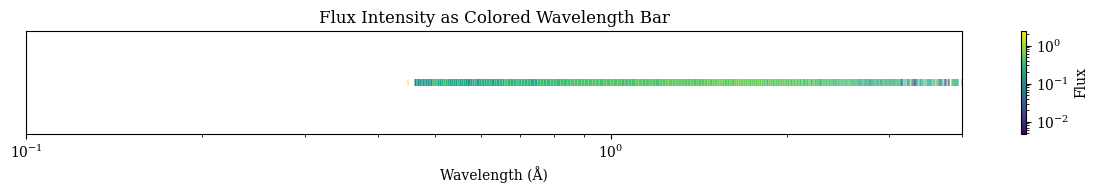

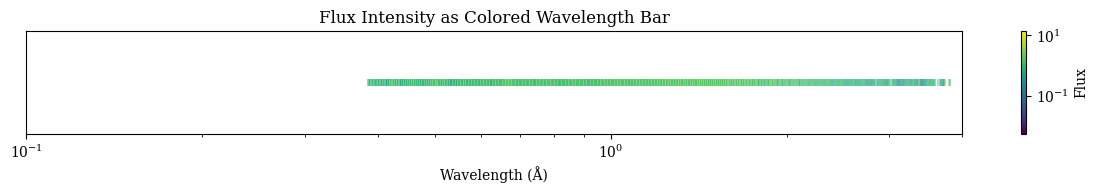

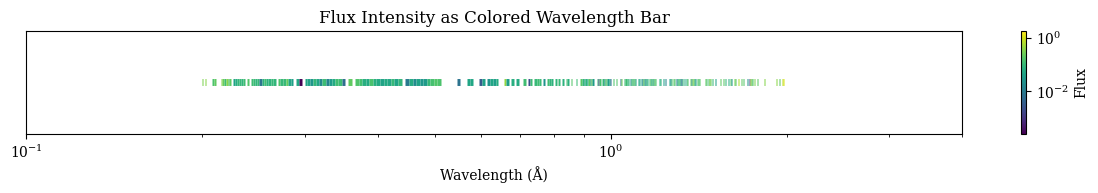

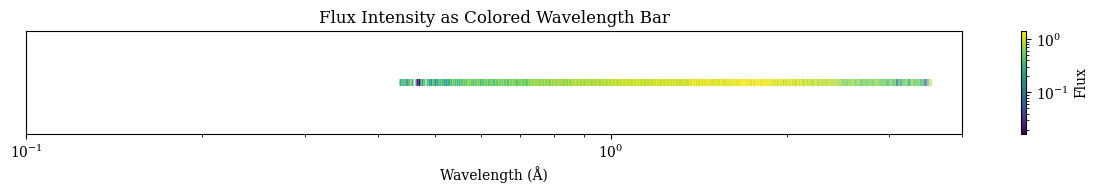

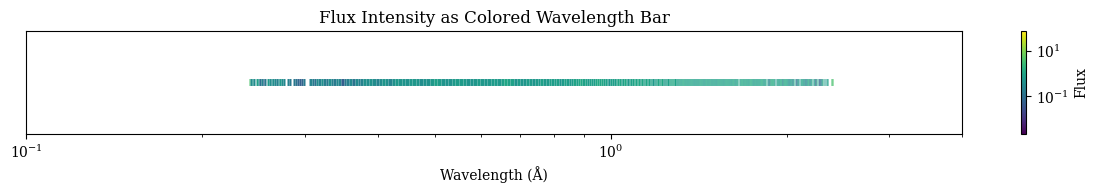

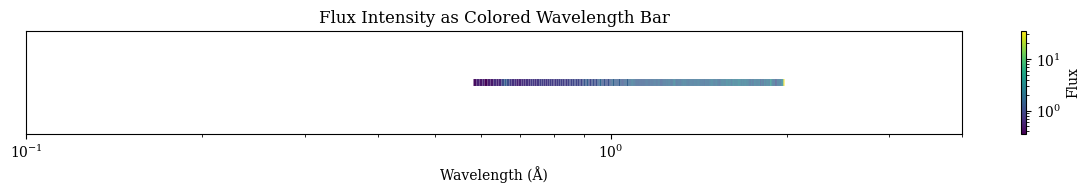

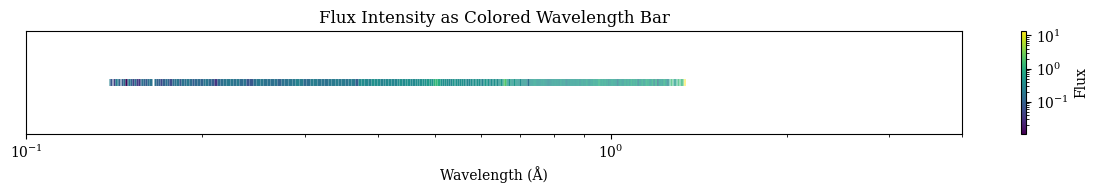

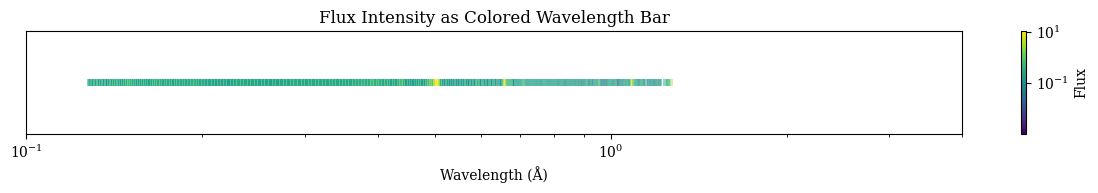

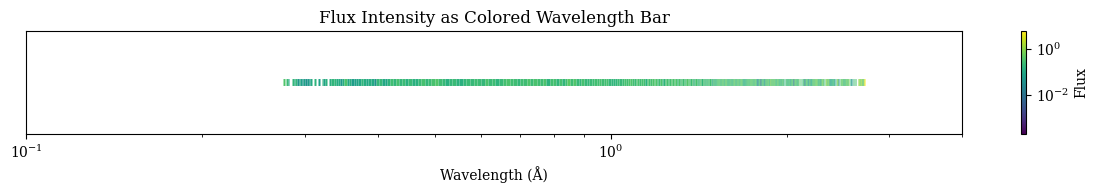

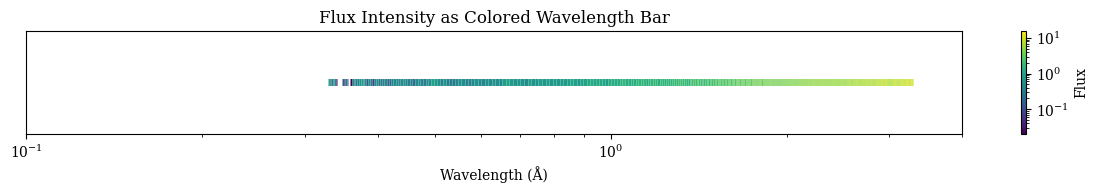

In [44]:
for file_path in prism_spectrum_list_has_redshift[0:10]:
    with io.fits.open(file_path) as hdul:
        wave= hdul[1].data['wave']
        flux= hdul[1].data['flux']

        redshift= redshift_list[np.where(prism_spectrum_list_has_redshift == file_path)[0][0]] if file_path in prism_spectrum_list_has_redshift else 0.0
        rest_wave= wave / (1 + redshift)

        flux_image = np.tile(flux, (10, 1))  # 扩展为10行，让颜色条可见

        y = 0  # 恒定高度
        segments = [((rest_wave[i], y), (rest_wave[i+1], y)) for i in range(len(rest_wave)-1)]
        flux_segment = flux[:-1]  # 每个段用前一个点的flux表示颜色

        # 创建颜色映射
        norm = mcolors.LogNorm()
        lc = LineCollection(segments, cmap='viridis', norm=norm)
        lc.set_array(flux_segment)
        lc.set_linewidth(5)  # 让线条像条带一样粗

        # 画图
        fig, ax = plt.subplots(figsize=(12, 2))
        ax.add_collection(lc)
        ax.set_xlim(0.1,4)
        ax.set_ylim(-1, 1)  # y恒定在0，这里上下加点范围美观
        ax.set_yticks([])
        ax.set_xlabel("Wavelength (Å)")
        cbar = plt.colorbar(lc, ax=ax)
        cbar.set_label("Flux")
        plt.title("Flux Intensity as Colored Wavelength Bar")
        plt.tight_layout()
        plt.xscale('log')  # 如果需要对波长进行对数缩放
        plt.show()